# **Microsoft_Global_Hackathon_2023**

Microsoft_Global_Hackathon_2023 participation for Early Warning and Monitoring System for Humanitarian Crisis Response.

In [113]:
import pandas as pd
import numpy as np
import requests

def fetchUrl(field):
    return requests.get(field).json()

def fetchField(field):
    dict_field = []
    errors = []
    temp_dict = requests.get('https://goadmin.ifrc.org/api/v2/'+field+'/?limit=200/').json()

    try:
        while temp_dict['next']:
            dict_field.extend(temp_dict['results'])
            temp_dict = fetchUrl(temp_dict['next'])
            dict_field.extend(temp_dict['results'])
        return pd.DataFrame.from_dict(dict_field)

    except:
        print('Problem accessing the table: ', field)
        print('========================')
        return None

go_appeals = fetchField('appeal')

In [114]:
go_appeals.head(3)

,aid,name,dtype,atype,atype_display,status,status_display,code,sector,num_beneficiaries,...,start_date,end_date,real_data_update,created_at,modified_at,event,needs_confirmation,country,region,id
0,17955,Guatemala - Dengue,"{'id': 1, 'summary': '', 'name': 'Epidemic', '...",0,DREF,0,Active,MDRGT020,Central America country cluster,5000,...,2023-09-14T00:00:00Z,2024-01-31T00:00:00Z,2023-09-14 22:38:00+00:00,2023-09-14 16:46:38.799657+00:00,2023-09-16 14:48:22.779937+00:00,NaN,True,"{'iso': 'GT', 'iso3': 'GTM', 'id': 76, 'record...","{'name': 1, 'id': 1, 'region_name': 'Americas'...",3781
1,17950,Liberia - Floods,"{'id': 12, 'summary': '', 'name': 'Flood', 'tr...",0,DREF,0,Active,MDRLR007,"Country cluster for Sierra Leone, Liberia, Gui...",8751,...,2023-09-13T00:00:00Z,2024-01-31T00:00:00Z,2023-09-13 14:26:00+00:00,2023-09-13 16:47:31.217838+00:00,2023-09-16 14:48:30.351736+00:00,NaN,True,"{'iso': 'LR', 'iso3': 'LBR', 'id': 103, 'recor...","{'name': 0, 'id': 0, 'region_name': 'Africa', ...",3779
2,17952,Libya - Flood Storm Daniel,"{'id': 12, 'summary': '', 'name': 'Flood', 'tr...",1,Emergency Appeal,0,Active,MDRLY005,Libya country office,200000,...,2023-09-12T00:00:00Z,2024-12-31T00:00:00Z,2023-09-15 13:17:00+00:00,2023-09-14 10:47:38.556835+00:00,2023-09-16 14:48:12.284577+00:00,6647.0,False,"{'iso': 'LY', 'iso3': 'LBY', 'id': 204, 'recor...","{'name': 4, 'id': 4, 'region_name': 'Middle Ea...",3780


### **We have extracted the data and first we need to convert JSON format data to dataframe for column dtype, country and region.**





In [115]:
# Convert the JSON column data into a DataFrame
df_normalized_dtype = pd.json_normalize(go_appeals['dtype'])
df_normalized_country = pd.json_normalize(go_appeals['country'])
df_normalized_region = pd.json_normalize(go_appeals['region'])

## **From extracted json data we found**

**Few columns has single value and can be removed.**

e.g.
*   translation_module_original_language
*   Column from dtype dataset Summery has no data, so can be removed.
*   Columns from contry dataset like 'iso', 'iso3', 'record_type', 'record_type_display', 'fdrs', 'average_household_size', 'translation_module_original_language', 'independent', 'is_deprecated' data values does not provide any significant values and can be removed.
*   Similarly 'id','label' columns from region dataset does not provide any significant values and can be removed.


**Also we can rename few columns to understand data better and quickly.**

e.g.
*   "name" to "crisis_type"
*   "id" to "crisis_id"
*   "name" to "country_name"
*   "id" to "country_id"
*   "name" to "region_id"

In [116]:
# Analzse and update normalized DataFrame for dtype column
#print(df_normalized_dtype)
df_normalized_dtype = df_normalized_dtype.drop(['translation_module_original_language','summary'], axis=1)
df_normalized_dtype = df_normalized_dtype.rename(columns={"name": "crisis_type", "id": "crisis_id"})

In [117]:
# Analzse and update normalized DataFrame for country column
#print(df_normalized_country)
df_normalized_country = df_normalized_country.drop(['iso','iso3','record_type','record_type_display','fdrs','average_household_size','translation_module_original_language','independent','is_deprecated'], axis=1)
df_normalized_country = df_normalized_country.rename(columns={"name": "country_name", "id": "country_id"})

In [118]:
# Analzse and update normalized DataFrame for region column
#print(df_normalized_region)
df_normalized_region = df_normalized_region.drop(['translation_module_original_language','id','label'], axis=1)
df_normalized_region = df_normalized_region.rename(columns={"name": "region_id"})

In [119]:
#print(go_appeals.shape)
#print(go_appeals.info())
#print(go_appeals.describe().transpose())

In [120]:
# Combine the original DataFrame with the new DataFrame
result_df1 = pd.concat([go_appeals, df_normalized_dtype, df_normalized_country, df_normalized_region], axis=1)

In [121]:
#print(result_df1.shape)
#print(result_df1.info())

**Now we will concatinate the data and again dperform some column drop and column rename activity for better analysis.**

In [122]:
# Drop the original JSON column and other coulumns having similar information.
result_df1 = result_df1.drop(columns=['dtype', 'country', 'region', 'aid', 'event', 'id', 'code'], axis=1)

In [123]:
result_df1 = result_df1.rename(columns={"name": "Crisis_title","atype_display": "disaster_type", "atype": "disaster_type_id", "status": "status_display_id"})

In [124]:
print(result_df1.shape)
print(result_df1.info())
#print(result_df1.head(3))

(7390, 22)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7390 entries, 0 to 7389
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Crisis_title        7390 non-null   object
 1   disaster_type_id    7390 non-null   int64 
 2   disaster_type       7390 non-null   object
 3   status_display_id   7390 non-null   int64 
 4   status_display      7390 non-null   object
 5   sector              7390 non-null   object
 6   num_beneficiaries   7390 non-null   int64 
 7   amount_requested    7390 non-null   object
 8   amount_funded       7390 non-null   object
 9   start_date          7390 non-null   object
 10  end_date            7390 non-null   object
 11  real_data_update    7370 non-null   object
 12  created_at          7390 non-null   object
 13  modified_at         7390 non-null   object
 14  needs_confirmation  7390 non-null   bool  
 15  crisis_id           7390 non-null   int64 
 16  crisis_type  

**We can also download the clean data for manual analysis which will give actual look and feel of the data..** :-)

In [125]:
#result_df1.to_csv('hackathon_data_updated1.csv')

### **Now lets start with the data analysis.**

In [126]:
result_df1.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
disaster_type_id,7390.0,0.471719,0.507834,0.0,0.0,0.0,1.0,3.0
status_display_id,7390.0,1.442219,0.927966,0.0,1.0,1.0,1.0,3.0
num_beneficiaries,7390.0,138489.836536,885130.722430,0.0,0.0,5000.0,35000.0,32000000.0
crisis_id,7390.0,10.099459,6.914182,1.0,5.0,12.0,13.0,66.0
country_id,7390.0,110.428823,60.649741,1.0,61.0,112.0,160.0,336.0
region_id,7390.0,1.367794,1.333858,0.0,0.0,1.0,2.0,4.0


In [127]:
# importing ploting libraries
import matplotlib as plt
import seaborn as sns
%matplotlib inline

In [128]:
#sns.pairplot(result_df1[['disaster_type_id','status_display_id','num_beneficiaries','crisis_id','country_id','region_id']]);

### **Lets check how many types of crisis we have for analysis.**

In [129]:
print("Types of Crisis reported: \n\n", result_df1['crisis_type'].unique())
print("No of Occurrences of Crisis: \n\n",result_df1['crisis_type'].value_counts())

Types of Crisis reported: 

 ['Epidemic' 'Flood' 'Drought' 'Earthquake' 'Population Movement'
 'Civil Unrest' 'Heat Wave' 'Pluvial/Flash Flood' 'Fire' 'Cyclone' 'Other'
 'Volcanic Eruption' 'Cold Wave' 'Complex Emergency' 'Landslide'
 'Storm Surge' 'Food Insecurity' 'Transport Accident' 'Tsunami'
 'Chemical Emergency' 'Insect Infestation' 'Biological Emergency']
No of Occurrences of Crisis: 

 Flood                   2136
Other                   1048
Epidemic                 812
Population Movement      712
Cyclone                  554
Earthquake               475
Drought                  381
Civil Unrest             306
Food Insecurity          248
Cold Wave                164
Fire                     147
Volcanic Eruption        107
Pluvial/Flash Flood      104
Storm Surge               64
Complex Emergency         50
Landslide                 30
Transport Accident        20
Heat Wave                 10
Tsunami                    8
Insect Infestation         8
Chemical Emergency     

<Axes: ylabel='crisis_type'>

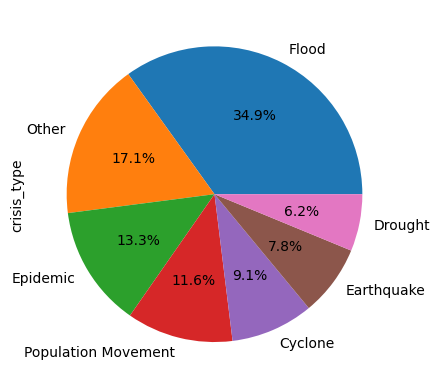

In [131]:
result_df1['crisis_type'].value_counts().head(7).plot.pie(autopct = '%1.1f%%')
#plt.gca().set_aspect('equal')

### **If we consider the most crisis, they are natural calameties like flood and human mistake like explosion, fire incidents.**

Crices and no_of_occurences.
1.  Flood             ---        2148
2.  Other             ---        1044
3.  Epidemic         ---           810
4.  Population Movement  ---       712
5.  Cyclone          ---           548
6.  Earthquake       ---          477
7.  Drought          ---           379
8.  Civil Unrest     ---            300
9.  Food Insecurity   ---          252
10. Cold Wave         ---          164
11. Fire             ---           149
12. Volcanic Eruption  ---         107



### **Now we will check which contries/states are prone to what kinds of Natural Disasters**

In [132]:
m=result_df1[['country_name','crisis_type']].groupby('country_name').describe()
m['crisis_type'].sort_values(by='count',ascending=False).head(5)

,count,unique,top,freq
country_name,,,,
Kenya,208,11,Flood,50
Philippines,162,9,Cyclone,81
India,152,11,Flood,85
Nigeria,150,10,Flood,36
Sudan,140,8,Flood,40


<Axes: ylabel='country_name'>

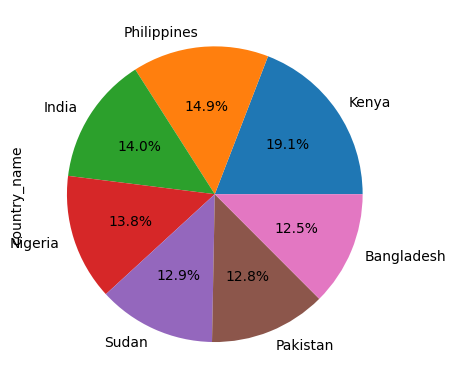

In [133]:
result_df1['country_name'].value_counts().head(7).plot.pie(autopct = '%1.1f%%')

### **Most of the contries like Kenia, India, Nigerai are impacted by flood where as Philipines is strucks with cyclone.**

### **Lets find contries/States that are at Maximum Risk.**

In [134]:
p = result_df1[['country_name','crisis_type']].groupby('country_name').count()
p.reset_index(inplace=True)
p=p.sort_values(by='crisis_type',ascending=False).head(10)
p

,country_name,crisis_type
81,Kenya,208
127,Philippines,162
71,India,152
117,Nigeria,150
152,Sudan,140
120,Pakistan,139
11,Bangladesh,136
167,Uganda,130
53,Ethiopia,118
174,Viet Nam,113


### **Plotting All cases reported of natural disasters per state.**

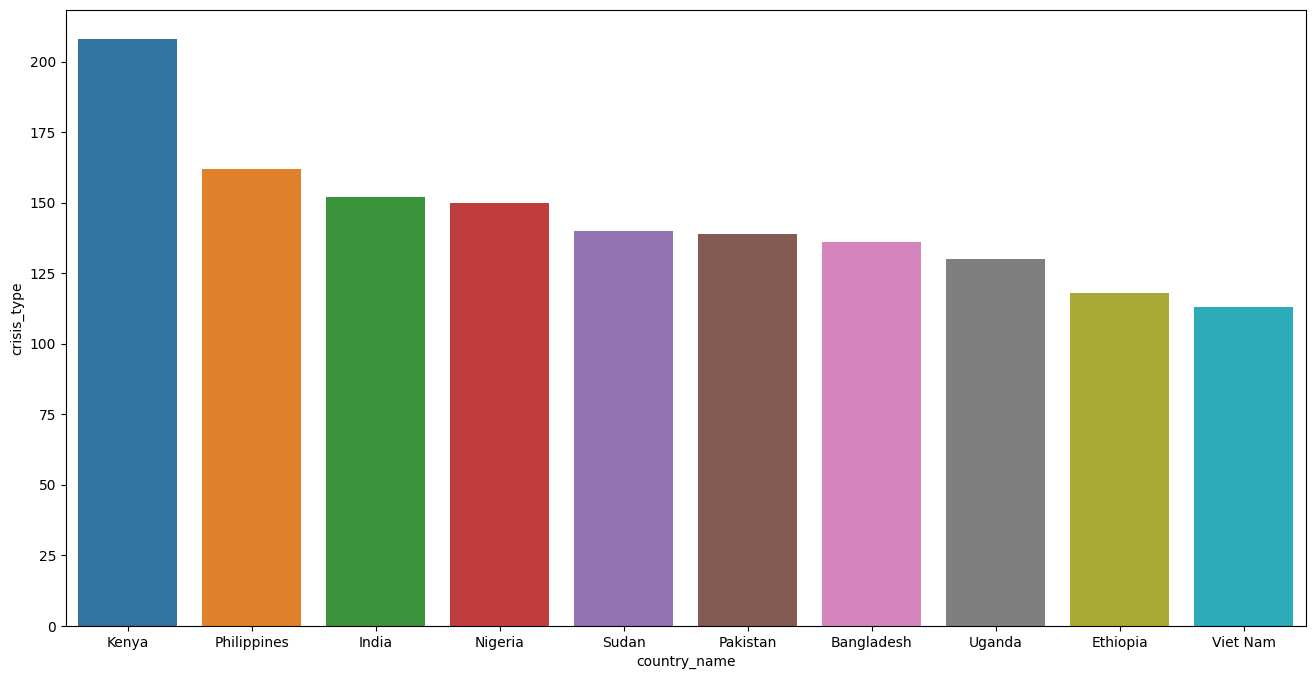

In [138]:
plt.pyplot.figure(figsize=(16,8))
sns.barplot(x="country_name", y="crisis_type", data=p,);

### **Kenya seems to be the most disaster Prone country, Lets find out more:**

In [139]:
print("Kenya mostly faces:\n")
result_df1[['country_name','crisis_type']].groupby('country_name').max().loc['Kenya']

Kenya mostly faces:



crisis_type    Volcanic Eruption
Name: Kenya, dtype: object

### **In Keniya most crises are reported due to Volcanic Eruption as per above analysis.**

In [140]:
# Kenya reports over time:
#m=result_df1.query('country_name=="Kenya"')['crisis_id'].value_counts().reset_index()
#m.head(10)

### **Now we will check which contries/states has most frequent crises.**

In [141]:
## Plotting count, unique and frequency from describe() function
#m=result_df1[['country_name','crisis_type']].groupby('country_name').describe()
#sns.pairplot(m['crisis_type'].reset_index(drop=True));

In [142]:
m=result_df1[['country_name','crisis_type']].groupby('country_name').describe()
m['crisis_type'].sort_values(by='freq',ascending=False)['freq'].head(10)

country_name
India                           85
Philippines                     81
Bolivia                         54
Uganda                          52
Pakistan                        51
Kenya                           50
Democratic Republic of Congo    50
Türkiye                         47
Iran, Islamic Republic of       44
Bangladesh                      42
Name: freq, dtype: object

<Axes: ylabel='freq'>

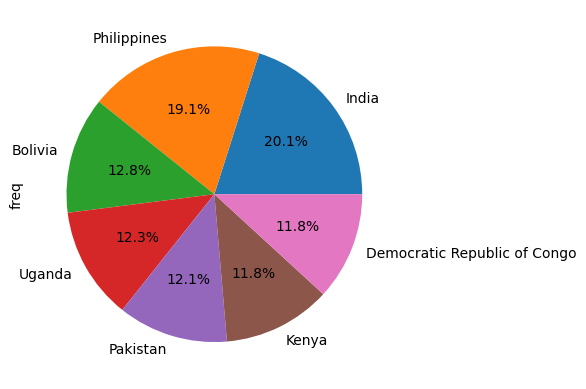

In [143]:
m['crisis_type'].sort_values(by='freq',ascending=False)['freq'].head(7).plot.pie(autopct = '%1.1f%%')

### **Lets check regions which are most impacted.**

<Axes: ylabel='region_name'>

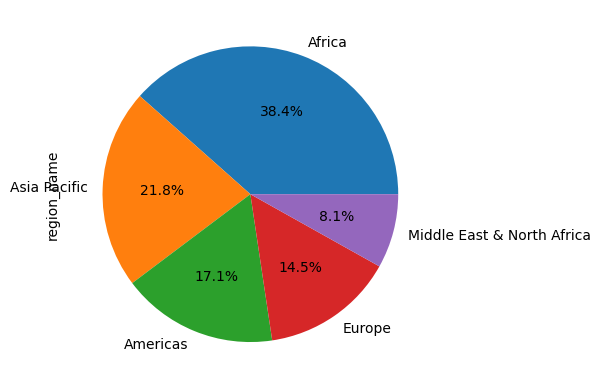

In [144]:
result_df1['region_name'].value_counts().head(7).plot.pie(autopct = '%1.1f%%')

### **Africa, Asia pasific and America regions are most impacted. Which is approx 78% of the world region.**

### Lets check sectors which are most impacted.

<Axes: ylabel='sector'>

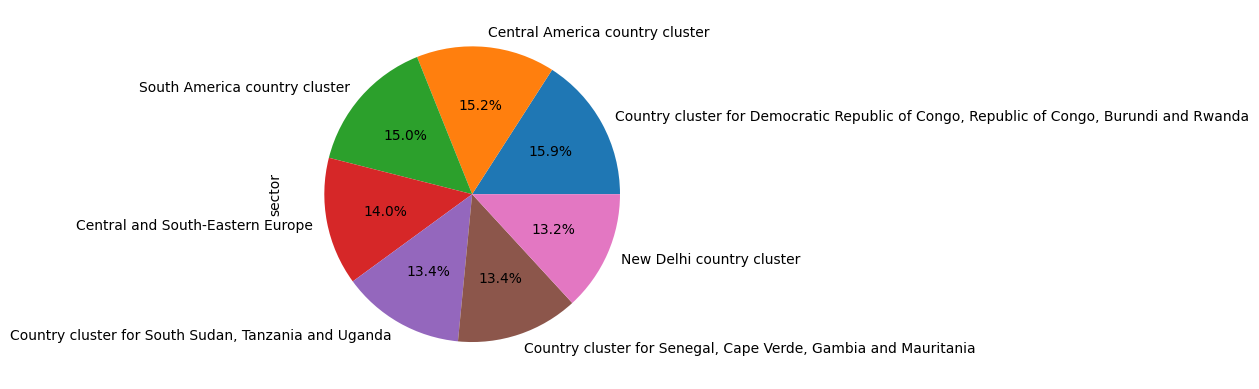

In [146]:
result_df1['sector'].value_counts().head(7).plot.pie(autopct = '%1.1f%%')

### **Looking at the dates on which maximum Statewide Disasters were reported:**

In [147]:
date1 = pd.to_datetime(result_df1['start_date']).dt
result_df1['year'] = date1.year
result_df1['month'] = date1.month
result_df1['day'] = date1.day
result_df1['time'] = date1.time
#del df['declaration_date']

In [148]:
result_df1['disaster_type'].value_counts()

DREF                     3928
Emergency Appeal         3446
Forecast Based Action       8
International Appeal        8
Name: disaster_type, dtype: int64

In [149]:
result_df1[['year','month','disaster_type']].groupby(['year','month']).describe()

disaster_type                              
                   count unique               top freq
year month                                            
1919 1                 1      1  Emergency Appeal    1
1921 1                 1      1  Emergency Appeal    1
1922 1                 1      1  Emergency Appeal    1
1923 1                 5      1  Emergency Appeal    5
1924 1                 4      1  Emergency Appeal    4
...                  ...    ...               ...  ...
2023 5                30      2              DREF   22
     6                10      1              DREF   10
     7                10      1              DREF   10
     8                22      1              DREF   22
     9                 8      2              DREF    6

[614 rows x 4 columns]

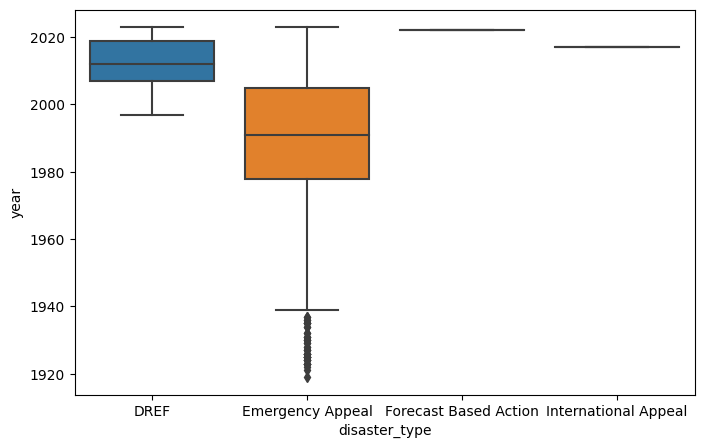

In [151]:
m=result_df1[['year','disaster_type']]
plt.pyplot.figure(figsize=(8,5))
sns.boxplot(x='disaster_type',y='year',data=m);

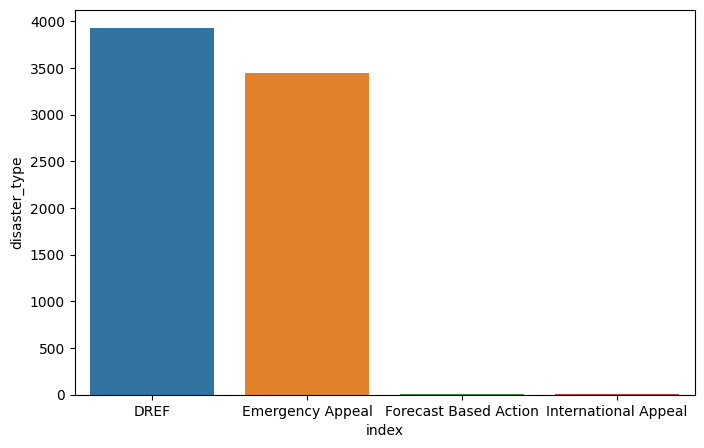

In [153]:
plt.pyplot.figure(figsize=(8,5))
sns.barplot(x='index',y='disaster_type',data=result_df1['disaster_type'].value_counts().reset_index());

### **Some Date-wise observations**

In [154]:
m=result_df1[['year','month','day','disaster_type']].groupby(['year','month','day']).count()
m.reset_index().sort_values(by='disaster_type',ascending=False)

,year,month,day,disaster_type
469,1997,1,1,226
529,1999,1,1,108
494,1998,1,1,108
596,2001,1,1,52
562,2000,1,1,48
...,...,...,...,...
2380,2023,6,6,1
2379,2023,6,1,1
1,1921,1,1,1
2,1922,1,1,1


### **As per above statistics, 226 disasters were reported on 1197-01-01.**

### **Let's get some insight into reports ...**